# 如何在Colab上使用OpenVINO運行人臉偵測

作者： Jack OmniXRI, 2023/5/4  

**註：本程式主要用於一般物件偵測模型，在人臉偵測僅適用 Intel Pre-Trained Model 「face-detection-xxxx」，其它模型則由於 output layer 定義不同暫無法使用。**


# 1.安裝OpenVINO

更新pip並安裝OpenVINO開發者最新版本(2022.3)  
如需指定特殊框架[extras]，如onnx, caffe, tensorflow, tensorflow2, mxnet, kaldi, pytorch等，可自行修改指令，如下範例：  
pip install openvino-dev[onnx,pytorch,tensorflow2]  

註：安裝後會出部份紅字錯誤訊息，如下所示  
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas~=1.5.3, but you have pandas 1.3.5 which is incompatible.

主要是因Colab要求的套件版本和OpenVINO安裝的不同，如沒有使用到這些模組，可暫時忽略這項錯誤，繼續執行下面範例。

In [1]:
import time # 引入時間模組

start = time.time() # 開始計算安裝時間

!python -m pip install --upgrade pip #更新 pip
!pip install openvino-dev # 開始安裝 OpenVINO開發者版最新版本

end = time.time() # 記錄結束時間
print("執行時間：%f 秒" % (end - start)) # 輸出時間計算結果

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 19.5 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.0.1
    Uninstalling pip-23.0.1:
      Successfully uninstalled pip-23.0.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 17.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 32.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 48.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 14.7 MB/s eta 0:00:00
  Created wheel for jstyleson: filename=jstyleson-0.0.2-py3-none-any.whl size=2398 sha256=2214c8d5777ab15e56c53796a2e98997c77a4c287c52aad7d1ea3878df772885
  Stored in directory: /root/.cache/pip/wheels/12/51/c6/a1e751db

列出已安裝套件包（可略過）

In [2]:
!pip list

Package                       Version
----------------------------- --------------------
absl-py                       1.4.0
addict                        2.4.0
alabaster                     0.7.13
albumentations                1.2.1
altair                        4.2.2
anyio                         3.6.2
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arviz                         0.15.1
astropy                       5.2.2
astunparse                    1.6.3
attrs                         23.1.0
audioread                     3.0.0
autograd                      1.5
Babel                         2.12.1
backcall                      0.2.0
beautifulsoup4                4.11.2
bleach                        6.0.0
blis                          0.7.9
blosc2                        2.0.0
bokeh                         2.4.3
branca                        0.6.0
CacheControl                  0.12.11
cached-property               1.5.2
cach

# 2.下載人臉測偵模型及測試用影像
使用 open model zoo tools 進行下載及轉換模型，若為Intel Pre-Trained Model則不需執行轉換。  
人臉原始影像來源：https://pic.52112.com/180327/180327_81/AJqv9zzUGU_small.jpg

In [3]:
!omz_downloader --name face-detection-0205
!omz_converter --name face-detection-0205
!wget -N https://raw.githubusercontent.com/OmniXRI/OpenVINO2022_on_Colab_Samples/main/data/face_ring.jpg

################|| Downloading face-detection-0205 ||################

========== Downloading /content/intel/face-detection-0205/FP32/face-detection-0205.xml
... 100%, 825 KB, 1783 KB/s, 0 seconds passed

========== Downloading /content/intel/face-detection-0205/FP32/face-detection-0205.bin
... 100%, 7861 KB, 10343 KB/s, 0 seconds passed

========== Downloading /content/intel/face-detection-0205/FP16/face-detection-0205.xml
... 100%, 971 KB, 2103 KB/s, 0 seconds passed

========== Downloading /content/intel/face-detection-0205/FP16/face-detection-0205.bin
... 100%, 3930 KB, 5944 KB/s, 0 seconds passed

========== Downloading /content/intel/face-detection-0205/FP16-INT8/face-detection-0205.xml
... 100%, 1359 KB, 2478 KB/s, 0 seconds passed

========== Downloading /content/intel/face-detection-0205/FP16-INT8/face-detection-0205.bin
... 100%, 2084 KB, 3725 KB/s, 0 seconds passed

========== Skipping face-detection-0205 (no conversions defined)

--2023-05-04 15:46:33--  https://raw.githubu

# 3.物件偵測範例

以下範例參考 OpenVINO Notebooks 
004-hello-detection.ipynb 修改而得。  
https://github.com/openvinotoolkit/openvino_notebooks/tree/main/notebooks/004-hello-detection 

## 3.1 引入必要函式庫

In [4]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from openvino.runtime import Core

## 3.2 載入及編譯模型
載入及編譯模型並定義輸入及輸出結構。  
註：由於Google Colab只提供Intel Xeon CPU，所以device_name只能設為CPU。

In [5]:
ie = Core()

model = ie.read_model(model="intel/face-detection-0205/FP16/face-detection-0205.xml")
compiled_model = ie.compile_model(model=model, device_name="CPU")

input_layer_ir = compiled_model.input(0)
output_layer_ir = compiled_model.output("boxes")

## 3.3 載入待測試影像並轉換格式

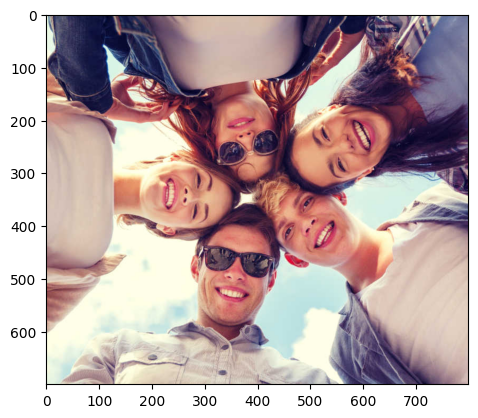

In [6]:
# 讀入待測試影像並將BGR格式轉換為RGB格式以滿足 MobileNet 模型需求
image = cv2.imread(filename="face_ring.jpg")

# N,C,H,W = 批次數量, 影像通道數, 影像高及寬
N, C, H, W = input_layer_ir.shape

# 調整影像尺寸至模型指定輸入尺寸
resized_image = cv2.resize(image, (W, H))

# # 擴展輸入陣列維度
input_image = np.expand_dims(resized_image.transpose(2, 0, 1), 0)

# 顯示待測試影像並將色彩格式由BGR變成RGB
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB));

## 3.4 進行推論並顯示結果

In [7]:
# 進行推論，取得偵測到的物件（人臉）資訊
boxes = compiled_model([input_image])[output_layer_ir]

# 移除空的物件
boxes = boxes[~np.all(boxes == 0, axis=1)]

定義「轉換結果到影像」函式

In [8]:
# 對每一個偵測的物件描述包括 [x_min, y_min, x_max, y_max, conf] 外框的左上角及右下角座標及置信度
# 輸入參數包含原始BGR格式影像、已縮放尺寸之影像、已偵測到的人臉資訊、最低接受門檻及置信度顯示
def convert_result_to_image(bgr_image, resized_image, boxes, threshold=0.3, conf_labels=True):
    # 定義色彩名稱及數值
    colors = {"red": (255, 0, 0), "green": (0, 255, 0)}

    # 取得原始影像尺寸並計算長寬縮放比
    (real_y, real_x), (resized_y, resized_x) = bgr_image.shape[:2], resized_image.shape[:2]
    ratio_x, ratio_y = real_x / resized_x, real_y / resized_y

    # 將原始BGR格式影像轉換成RGB格式
    rgb_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)

    # 重覆處理非空的物件外框資訊
    for box in boxes:
        # 確認取得之物件外框其置信度是否已高於門檻
        conf = box[-1]
        if conf > threshold:
            # 若是則將物件外框浮點數座標轉換成實際繪圖的整數座標
            # 若座標在影像最高處則略微調低以利繪圖及可視。
            (x_min, y_min, x_max, y_max) = [
                int(max(corner_position * ratio_y, 10)) if idx % 2
                else int(corner_position * ratio_x)
                for idx, corner_position in enumerate(box[:-1])
            ]

            # 繪製物件外框（綠色，線粗3pt）
            rgb_image = cv2.rectangle(rgb_image, (x_min, y_min), (x_max, y_max), colors["green"], 3)

            # 若要顯示置信度，則繪製文字到圖上（紅字，0.8倍文字大小）
            if conf_labels:
                rgb_image = cv2.putText(
                    rgb_image,
                    f"{conf:.2f}",
                    (x_min, y_min - 10),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.8,
                    colors["red"],
                    1,
                    cv2.LINE_AA,
                )

    return rgb_image

呼叫函式，繪製物件（人臉）的外框，可選擇性的開啟顯示置信度訊息(conf_labels=True/False)。

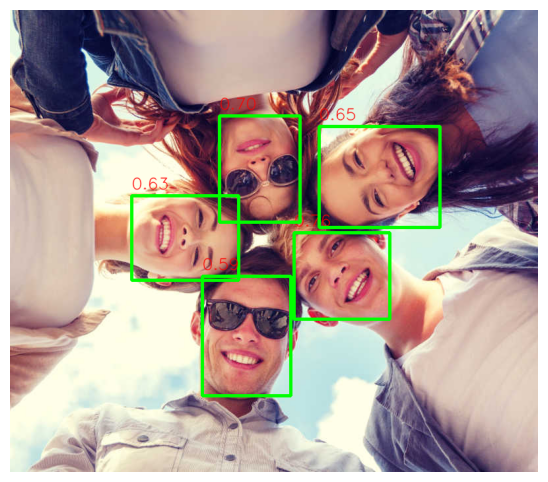

In [9]:
plt.figure(figsize=(10, 6))
plt.axis("off")
plt.imshow(convert_result_to_image(image, resized_image, boxes, conf_labels=True));